# Task 2: Build Time Series Forecasting Models

## Objective
Develop, train, and evaluate time series forecasting models to predict Tesla's future stock prices.

## Models
- ARIMA/SARIMA
- LSTM

## Data Preparation
We will focus on Predicting **Tesla (TSLA)** stock prices.

2026-01-25 19:00:01,093 - INFO - Fetching data for ['TSLA', 'BND', 'SPY'] from 2015-01-01 to 2026-01-15...
[*********************100%***********************]  3 of 3 completed
2026-01-25 19:00:01,196 - INFO - Data fetched successfully.
2026-01-25 19:00:01,196 - INFO - Cleaning data...
2026-01-25 19:00:01,197 - INFO - Data cleaning complete.


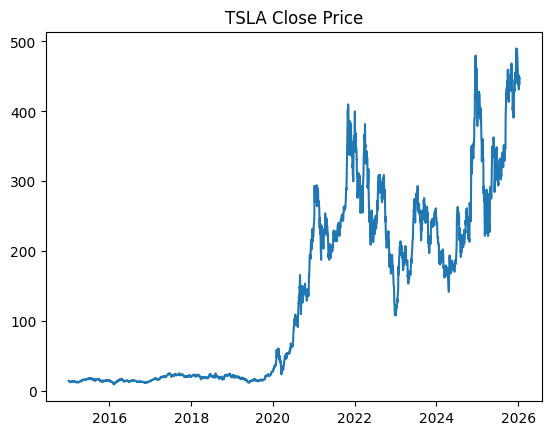

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import pmdarima as pm
import importlib

# Add src to path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

# Reload models to pick up changes
import models
importlib.reload(models)

from data_loader import fetch_data, clean_data
from models import split_data, train_arima, forecast_arima, train_lstm, forecast_lstm, evaluate_forecast

# Load Data
data_path = "../data/processed/historical_data.csv"
if os.path.exists(data_path):
    data = pd.read_csv(data_path, index_col=0, parse_dates=True, header=[0, 1]) # Adjust header for MultiIndex
    # If flatten needed:
    # data = pd.read_csv(data_path, index_col=0, parse_dates=True)
else:
    # Fetch if not exists
    assets = ['TSLA', 'BND', 'SPY']
    data = clean_data(fetch_data(assets, '2015-01-01', '2026-01-15'))

# Filter for TSLA Close
# Note: Adjust column access based on actual CSV structure
# Assuming MultiIndex (Ticker, Attributes)
try:
    tsla_close = data['TSLA']['Close']
except:
    tsla_close = data['TSLA'] # If flat named 'TSLA' or similar

tsla_close.dropna(inplace=True)
plt.plot(tsla_close)
plt.title("TSLA Close Price")
plt.show()

## 1. Train/Test Split

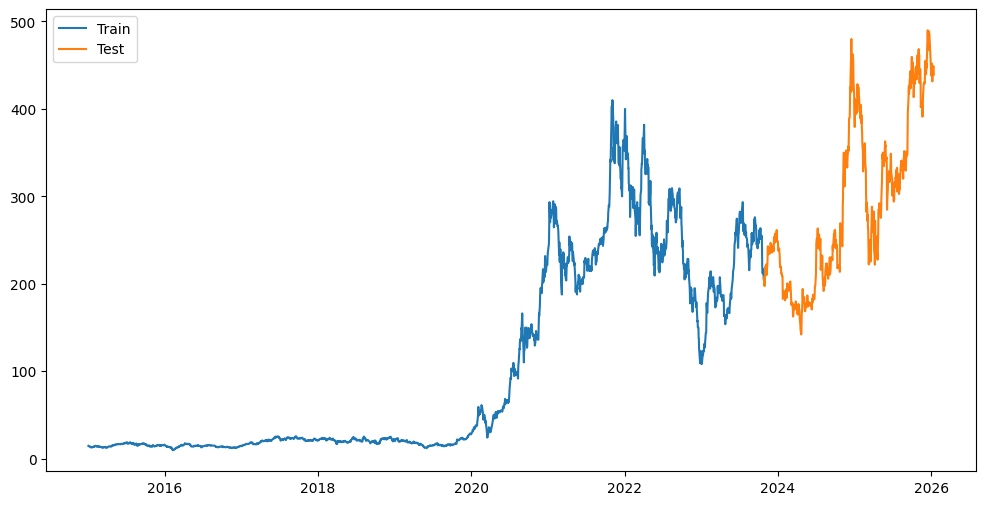

In [8]:
train, test = split_data(tsla_close, train_size=0.8)

plt.figure(figsize=(12,6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.legend()
plt.show()

## 2. ARIMA Model
We use `auto_arima` to find optimal parameters.

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=14030.013, Time=1.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14028.054, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14027.854, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14027.925, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14026.560, Time=0.03 sec


2026-01-25 18:58:04,688 - INFO - Training ARIMA with order (0, 1, 0)...


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=14028.187, Time=0.29 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.553 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2220
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -7012.280
Date:                Sun, 25 Jan 2026   AIC                          14026.560
Time:                        18:58:04   BIC                          14032.265
Sample:                             0   HQIC                         14028.644
                               - 2220                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        32.5364      0.367     88.639      0.000      31.817

/home/marshy/FOSS/repos/tenx/w9/portfolio-optimization/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/marshy/FOSS/repos/tenx/w9/portfolio-optimization/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/marshy/FOSS/repos/tenx/w9/portfolio-optimization/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/marshy/FOSS/repos/tenx/w9/portfolio-optimization/.venv/lib/python3.13/site-packages/statsmodel

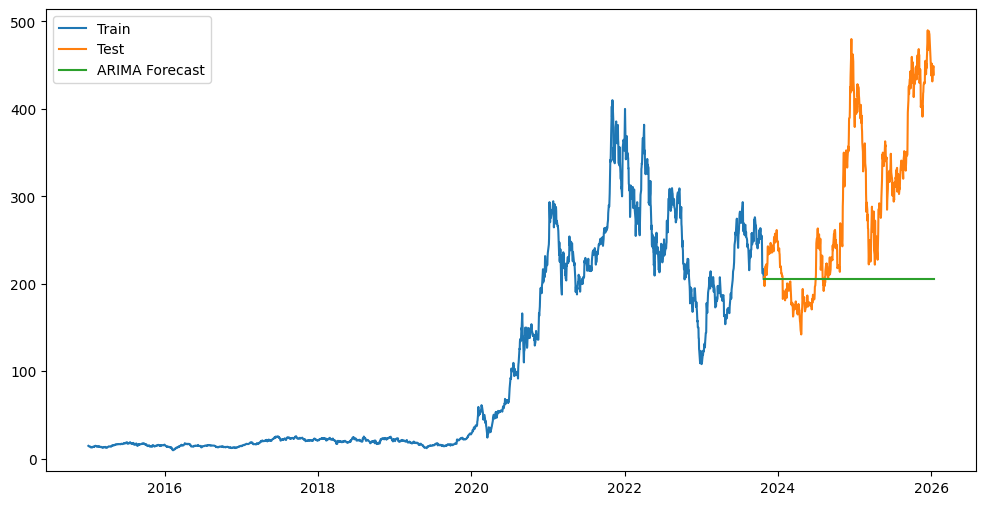

ARIMA Metrics: {'MAE': 96.25256174448374, 'RMSE': np.float64(126.67072471510338), 'MAPE': np.float64(27.97080871909089)}


In [9]:
# Find best parameters
# Note: limiting max_p/q/d for speed in demo
model_auto = pm.auto_arima(train, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
print(model_auto.summary())

# Train Final ARIMA
model_fit = train_arima(train, order=model_auto.order)

# Forecast
forecast_arima_res = forecast_arima(model_fit, steps=len(test))
# Use .values to avoid index alignment issues if forecast index differs from test index
forecast_series = pd.Series(forecast_arima_res.values, index=test.index)

# Plot
plt.figure(figsize=(12,6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast_series, label='ARIMA Forecast')
plt.legend()
plt.show()

# Evaluate
arima_metrics = evaluate_forecast(test.values, forecast_series.values)
print("ARIMA Metrics:", arima_metrics)

## 3. LSTM Model

2026-01-25 19:00:13,392 - INFO - Training LSTM...


Epoch 1/10


/home/marshy/FOSS/repos/tenx/w9/portfolio-optimization/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0108
Epoch 2/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0016
Epoch 3/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0013
Epoch 4/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0011
Epoch 5/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 9.6666e-04
Epoch 6/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 8.4089e-04
Epoch 7/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 8.3569e-04
Epoch 8/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 6.7698e-04
Epoch 9/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 6.6699e-04
Epoch 10/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.0731e-04


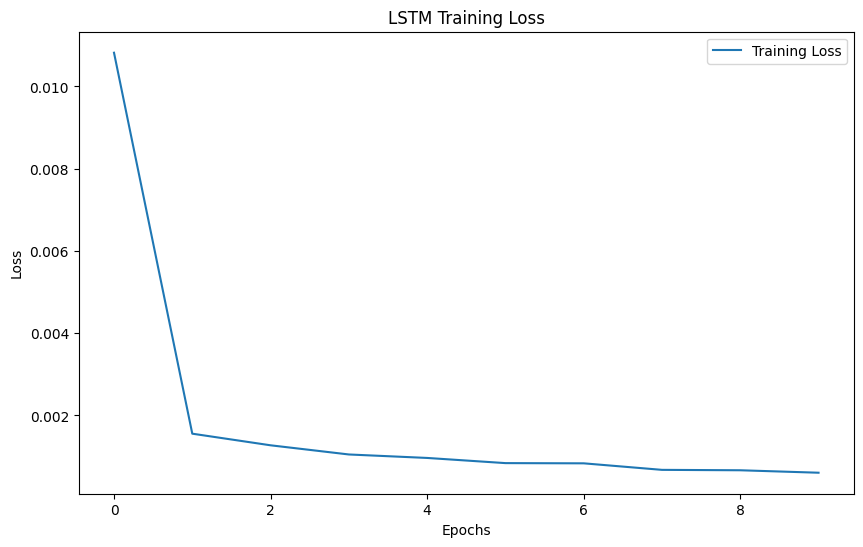

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━

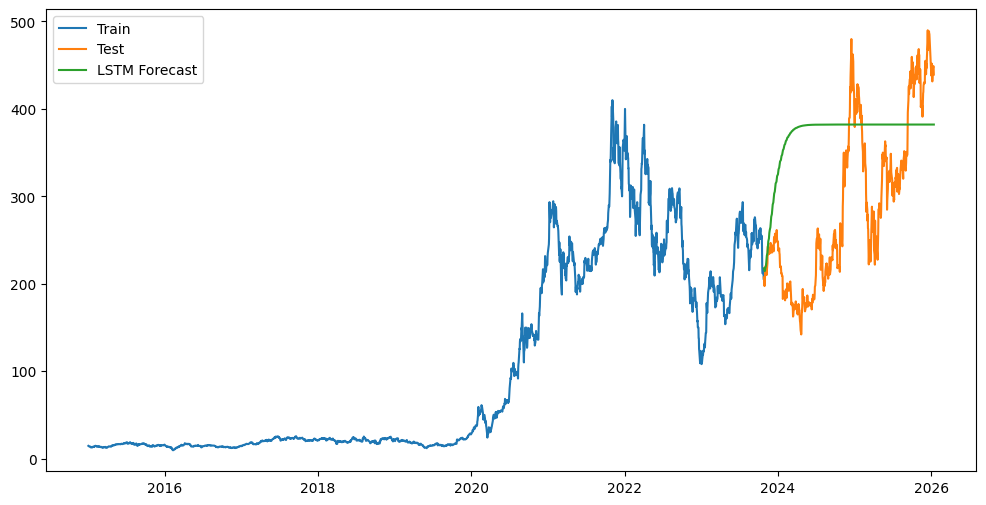

LSTM Metrics: {'MAE': 101.92910238729941, 'RMSE': np.float64(120.68298808904179), 'MAPE': np.float64(45.16262446549853)}


In [13]:
seq_length = 60
lstm_model, scaler, history = train_lstm(train, seq_length=seq_length, epochs=10, batch_size=32)

# Plot Loss Curve
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('LSTM Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Forecast on Test Set
# We need to feed the model the sequence leading up to the test set
# Actually, for one-step ahead on test set, we can use valid history. 
# But for multi-step forecast (future unseen), we use the recurrent method.
# To evaluate fairly on Test set as if it were future, we should use the recurrent forecast from end of Train.

forecast_lstm_res = forecast_lstm(lstm_model, train, scaler, seq_length=seq_length, steps=len(test))
forecast_lstm_series = pd.Series(forecast_lstm_res.flatten(), index=test.index)

# Plot
plt.figure(figsize=(12,6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast_lstm_series, label='LSTM Forecast')
plt.legend()
plt.show()

# Evaluate
lstm_metrics = evaluate_forecast(test.values, forecast_lstm_series.values)
print("LSTM Metrics:", lstm_metrics)

## 4. Model Comparison

In [14]:
comparison = pd.DataFrame([arima_metrics, lstm_metrics], index=['ARIMA', 'LSTM'])
print(comparison)


              MAE        RMSE       MAPE
ARIMA   96.252562  126.670725  27.970809
LSTM   101.929102  120.682988  45.162624
